# Pangenome UMAP exploration

## Setup

In [1]:
## Notebook config

import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
# Notebook imports

import ast
import os
import pickle
import collections 


from Bio import Entrez, SeqIO
from graphdatascience import GraphDataScience
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import umap

/home/ec2-user/miniconda3/envs/rnalab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATASET_DIR = './dataset/'
PROJECTION_NAME_PREFIX = 'exploration_projection_'
RANDOM_SEED = 42

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')


In [4]:
# GDS utils
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def get_projection_name(version=1):
    return PROJECTION_NAME_PREFIX + str(version)

def get_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    projection = gds.graph.project(
        graph_name=projection_name,
        node_spec=[
            'Genome',
            'FuncDomain',
            'FuncDomainSet',
            'FuncDomainClan',
        ],
        relationship_spec={
            'HasReg': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} }},
            'HasMember': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} }},
            'hasNextDomainSet': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} }},
            'hasClanEntry': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1} } },
            'homologousTo': {'orientation': 'NATURAL', 'properties': {'identity': {'defaultValue': 0} }},
            'hasClanHomology': {'orientation': 'UNDIRECTED', 'properties': {'identity': {'defaultValue': 1}, 'linkscore': {'defaultValue': 1}}},
        },
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))


In [6]:
# Create GDS projection

version = 1
projection_name = get_projection_name(version)
gds = get_gds_client()
delete_projection(gds, projection_name)
projection = get_projection(gds, projection_name)
print(projection)

Unable to connect to the Neo4j DBMS. Trying again...
Unable to connect to the Neo4j DBMS. Trying again...
Unable to connect to the Neo4j DBMS. Trying again...
Unable to connect to the Neo4j DBMS. Trying again...
Unable to connect to the Neo4j DBMS. Trying again...


GraphCreateResult(graph=Graph({'graphName': 'exploration_projection_1', 'nodeCount': 33453, 'relationshipCount': 1345820, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'HasReg': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'identity': {'aggregation': 'DEFAULT', 'property': 'identity', 'defaultValue': 1}}, 'type': 'HasReg'}, 'hasClanHomology': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'identity': {'aggregation': 'DEFAULT', 'property': 'identity', 'defaultValue': 1}, 'linkscore': {'aggregation': 'DEFAULT', 'property': 'linkscore', 'defaultValue': 1}}, 'type': 'hasClanHomology'}, 'HasMember': {'aggregation': 'DEFAULT', 'orientation': 'UNDIRECTED', 'indexInverse': False, 'properties': {'identity': {'aggregation': 'DEFAULT', 'property': 'identity', 'defaultValue': 1}}, 'type': 'HasMember'}, 'homologousTo': {'aggregation': 'DEFAULT', 'orientation': 'NATURAL', 'indexInverse

## Graph analysis (Neo4j GDS)

In [10]:
# Add node features (degree, community, centrality)

df_degree = gds.degree.mutate(
    G=gds.graph.get(projection_name),
    mutateProperty='degree',
    nodeLabels=[
        'Genome',
        'FuncDomain',
        'FuncDomainSet',
        'FuncDomainClan',
    ],
    relationshipTypes=[
        'HasReg',
        'HasMember',
        'hasNextDomainSet',
        'hasClanEntry',
        'homologousTo',
        'hasClanHomology',
    ],
)

# community = gds.pageRank.mutate(
#     G=gds.graph.get(projection_name),
#     mutateProperty='community',
#     maxIterations=20,
#     dampingFactor=0.85,
#     nodeLabels=["*"],
#     relationshipTypes=["*"],
# )

# community = gds.pageRank.stats(
#     G=gds.graph.get(projection_name),
#     relationshipTypes=["*"],
#     nodeLabels=["*"],
#     maxIterations=1000,
# )


In [7]:
# Create embeddings on full projection (not used for ml pipeline)

# gds.node2vec.mutate(
#     G=gds.graph.get(projection_name),
#     mutateProperty='node2vec',
#     nodeLabels=["*"],
#     relationshipTypes=["*"],
#     # relationshipWeightProperty='identity',
#     randomSeed=RANDOM_SEED,
# )

# gds.hashgnn.mutate(
#     G=gds.graph.get(projection_name),
#     mutateProperty='hashgnn',
#     randomSeed=RANDOM_SEED,
#     nodeLabels=["*"],
#     relationshipTypes=["*"],
#     iterations=10, # maximum number of hops
#     heterogeneous=True,
#     embeddingDensity=128,
#     neighborInfluence=0.7,
#     generateFeatures={
#         'dimension': 64, # dimension of the embedding vector
#         'densityLevel': 3, # number of initial values equalling 1
#     },
# )

gds.fastRP.mutate(
    G=gds.graph.get(projection_name),
    # featureProperties=['community'],
    mutateProperty='fastrp',
    randomSeed=RANDOM_SEED,
    relationshipWeightProperty='identity',
    nodeLabels=["*"],
    relationshipTypes=[
        # "*",
        'HasReg',
        'HasMember',
        'hasNextDomainSet',
        'hasClanEntry',
        # 'homologousTo',
        'hasClanHomology',
    ],
    embeddingDimension=384,
    normalizationStrength=-0.5,
    # nodeSelfInfluence=2,
)
    
# try:
#     gds.model.get('graphsage').drop()
# except:
#     pass
# gds.beta.graphSage.train(
#     G=gds.graph.get(projection_name),
#     modelName='graphsage',
#     featureProperties=['degree'],
# )
# gds.beta.graphSage.mutate(
#     G=gds.graph.get(projection_name),
#     mutateProperty='graphsage',
#     nodeLabels=["*"],
#     relationshipTypes=["*"],
#     modelName='graphsage',
# )

FastRP: 100%|██████████| 100.0/100 [00:02<00:00, 49.61%/s]


nodePropertiesWritten                                                33453
mutateMillis                                                             3
nodeCount                                                            33453
preProcessingMillis                                                      1
computeMillis                                                         2292
configuration            {'randomSeed': 42, 'mutateProperty': 'fastrp',...
Name: 0, dtype: object

## Plots


In [8]:
# Plot configuration

target_property = 'fastrp' # 'degree','node2vec', 'hashgnn', 'graphsage', 'fastrp', 'community',
node_label = 'Genome'
target_rank = 'phylum'
rank_col = 'top' + target_rank.capitalize()
class_label = 'topPhylum' # 'genus', 'family', 'order'

In [11]:
# Export projection to df for plotting

# Note: exporting multiple properties creates duplicate rows
def export_nodes_from_projection(property):
    exported_projection = gds.graph.nodeProperties.stream(
        get_projection(gds, get_projection_name()),
        node_properties=[property],
        separate_property_columns=True,
        db_node_properties=['accession', 'name', 'annotation', 'source', 'taxonomy'],
        listNodeLabels=True,
    )
    exported_projection['nodeLabels'] = exported_projection['nodeLabels'].apply(lambda x: x[0])
    return exported_projection


exported_projection = export_nodes_from_projection(target_property)
exported_degrees = export_nodes_from_projection('degree')
exported_degrees = exported_degrees[['nodeId', 'degree']]
exported_projection = exported_projection.merge(exported_degrees, on='nodeId')

print(exported_projection.nodeLabels.value_counts())

assert len(exported_projection.loc[
    exported_projection['nodeLabels'] == 'Genome'
])  == 6453

nodeLabels
FuncDomain        26314
Genome             6453
FuncDomainSet       609
FuncDomainClan       77
Name: count, dtype: int64


In [12]:
# Enrich Genomes with taxonomic labels from ICTV

def get_taxonomy_by_idx(tax_str, idx):
    try:
        return tax_str.split(';')[idx].strip()
    except:
        return None

def enrich_data_with_tax_labels(df, rank):
    rank_getters = {
        'clade': 0,
        'kingdom': 2,
        'phylum': 4,
        'class': 6,
        'order': 8,
        'family': 10,
        'genus': 12,
        'species': 14,
    }
    df[rank] = None
    
    df.loc[df['nodeLabels'] == 'Genome', rank] = df.loc[
        df['nodeLabels'] == 'Genome', 'taxonomy'].apply(get_taxonomy_by_idx, args=[rank_getters[rank]])
    return df


for rank in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
    exported_projection = enrich_data_with_tax_labels(exported_projection, rank)


In [13]:
# Enrich DomainSets with pfam entry type

nodes_db = gds.util.asNodes(exported_projection.loc[
    exported_projection['nodeLabels'] == 'FuncDomainSet', 'nodeId'].to_list())
nodes_df = pd.DataFrame([(node.id, node["pfam_subtype"]) for node in nodes_db], columns=["nodeId", "pfam_subtype"])
print(nodes_df.pfam_subtype.value_counts())

if 'pfam_subtype' in exported_projection.columns:
    exported_projection.drop(columns=['pfam_subtype'], inplace=True)

exported_projection = exported_projection.merge(nodes_df, left_on="nodeId", right_on="nodeId", how="left")

assert exported_projection.loc[
    exported_projection['nodeLabels'] == 'FuncDomainSet', 'pfam_subtype'].isna().sum() == 0


pfam_subtype
Family         365
Domain         232
Repeat           6
Motif            3
Coiled-coil      3
Name: count, dtype: int64


/tmp/ipykernel_4405/2238584612.py:5: DeprecationWarning: `id` is deprecated, use `element_id` instead
  nodes_df = pd.DataFrame([(node.id, node["pfam_subtype"]) for node in nodes_db], columns=["nodeId", "pfam_subtype"])


In [14]:
# Enrich domains with top rank labels

def add_top_k_rank_col(df, k=10):
    # only modify node_label
    df[rank_col] = None
    top_k = df.loc[df['nodeLabels'] == node_label, target_rank].value_counts().index[:k]
    df.loc[df['nodeLabels'] == node_label, rank_col] = df.loc[
        df['nodeLabels'] == node_label, target_rank]
    df.loc[
        (df['nodeLabels'] == node_label) &
        (~df[target_rank].isin(top_k)), rank_col] = 'Other'
    return df

exported_projection = add_top_k_rank_col(exported_projection)
print(exported_projection[rank_col].value_counts())


topPhylum
Negarnaviricota     2434
Pisuviricota        1556
Lenarviricota       1036
Kitrinoviricota      977
Duplornaviricota     291
Artverviricota       138
Null                  21
Name: count, dtype: int64


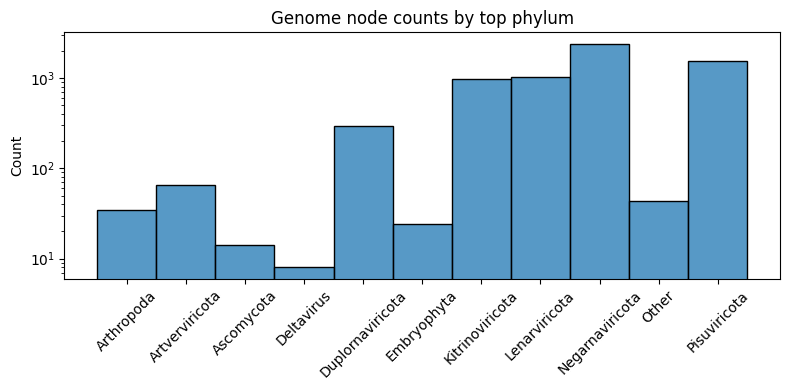

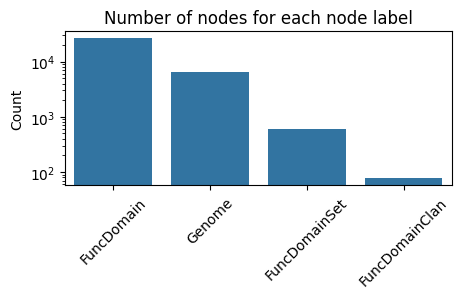

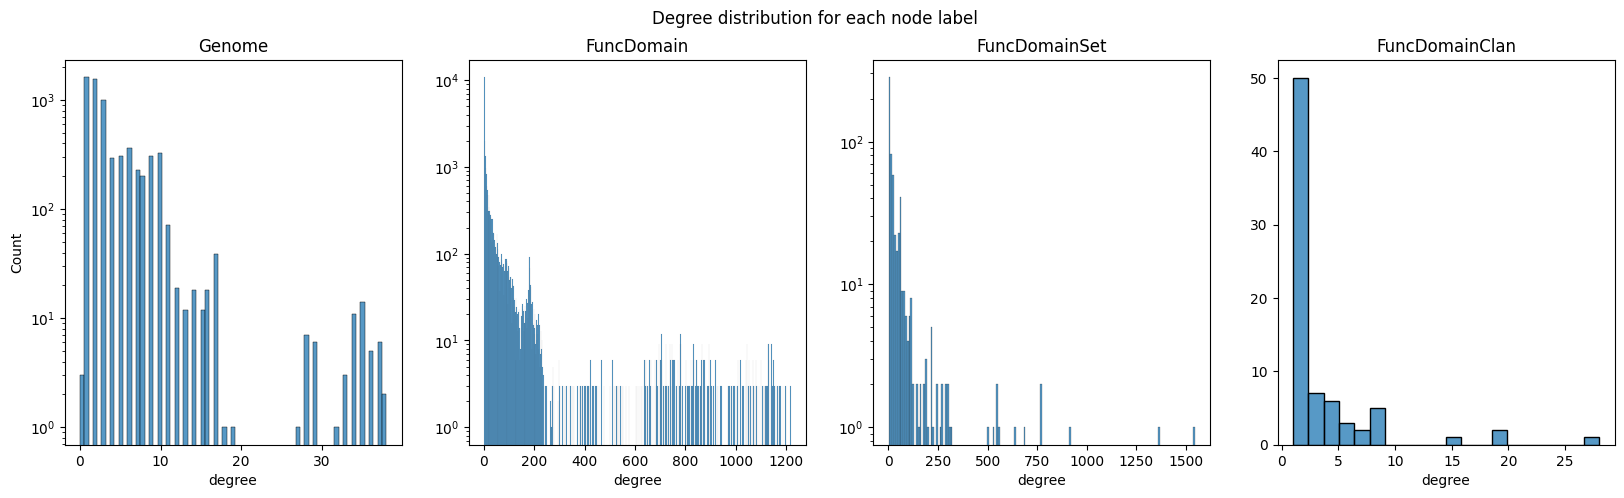

In [81]:
# Graph count distribution plots

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sorted_df = exported_projection.loc[exported_projection['nodeLabels'] == 'Genome', class_label].sort_values()
sns.histplot(sorted_df, ax=ax)
ax.set_yscale('log')
ax.set_title(f'Genome node counts by top {target_rank}')
ax.set_xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
# fig.savefig(FIGURE_DIR + 'graph_genome_taxonomy_' + class_label + '.png')


# Plot number of nodes for each node label
counts = exported_projection['nodeLabels'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
sns.barplot(x=counts.index, y=counts.values)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.title('Number of nodes for each node label')
plt.show()
# fig.savefig(FIGURE_DIR + 'graph_node_label_counts.png')


# Plot degree distribution for each node label
if 'degree' in exported_projection.columns:
    exported_projection['degree'] = exported_projection['degree'].apply(lambda x: int(x))

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    sns.histplot(exported_projection.loc[exported_projection['nodeLabels'] == 'Genome', 'degree'], ax=ax[0])
    ax[0].set_title('Genome')
    ax[0].set_yscale('log')

    sns.histplot(exported_projection.loc[exported_projection['nodeLabels'] == 'FuncDomain', 'degree'], ax=ax[1])
    ax[1].set_title('FuncDomain')
    ax[1].set_yscale('log')
    ax[1].set_ylabel('')

    sns.histplot(exported_projection.loc[exported_projection['nodeLabels'] == 'FuncDomainSet', 'degree'], ax=ax[2])
    ax[2].set_title('FuncDomainSet')
    ax[2].set_yscale('log')
    ax[2].set_ylabel('')

    sns.histplot(exported_projection.loc[exported_projection['nodeLabels'] == 'FuncDomainClan', 'degree'], ax=ax[3])
    ax[3].set_title('FuncDomainClan')
    # ax[3].set_yscale('log')
    ax[3].set_ylabel('')

    # add title
    plt.suptitle('Degree distribution for each node label')
    plt.show()
    # fig.savefig(FIGURE_DIR + 'graph_degree_distribution.png')

### Taxonomy UMAP plots

In [15]:
# umap embedding
all_embeddings = pd.DataFrame(exported_projection[target_property].to_list())

reducer = umap.UMAP()
# reducer = umap.UMAP(unique=True)
umap_emb = reducer.fit_transform(all_embeddings)

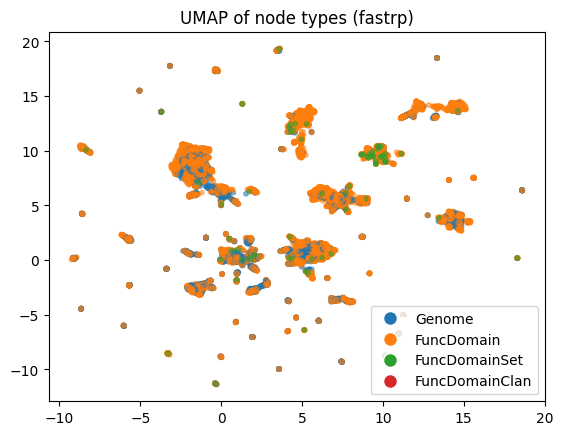

In [16]:
# Plot Umap of node types

plt.scatter(
    umap_emb[:, 0],
    umap_emb[:, 1],
    c=[
        sns.color_palette()[x]
        for x in exported_projection.nodeLabels.map({
            "Genome": 0, "FuncDomain": 1, "FuncDomainSet": 1, "FuncDomainClan": 2,
        })
    ],
    s=10,
    alpha=0.5,
)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Genome',
               markerfacecolor=sns.color_palette()[0], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='FuncDomain',
               markerfacecolor=sns.color_palette()[1], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='FuncDomainSet',
                markerfacecolor=sns.color_palette()[2], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='FuncDomainClan',
                markerfacecolor=sns.color_palette()[3], markersize=10),
])
plt.title('UMAP of node types' + ' (' + target_property + ')')
fig = plt.gcf()
plt.show()
# fig.savefig(FIGURE_DIR + target_property + '_umap_node_types.png', dpi=100)

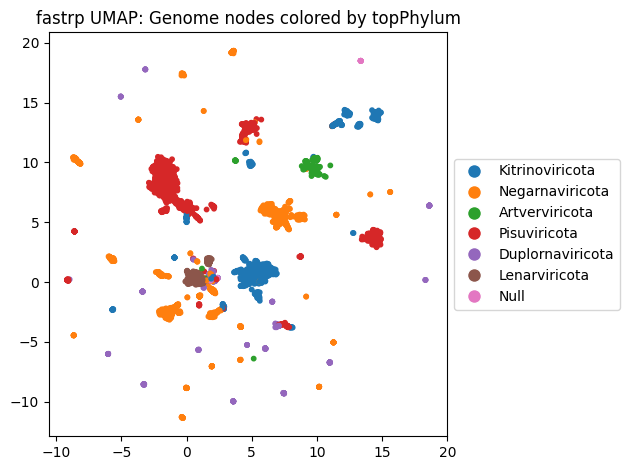

In [17]:
# Plot UMAP of target node label, colored by top k target rank

# create color palette for genome nodes based on class_label
unique_rank = exported_projection[class_label].unique()
unique_rank = unique_rank[unique_rank != '']
unique_rank = unique_rank[~pd.isnull(unique_rank)]
rank_palette = sns.color_palette("tab10", len(unique_rank))
rank_palette = {genus: color for genus, color in zip(unique_rank, rank_palette)}
exported_projection['label_color'] = exported_projection[class_label].map(rank_palette)


plt.scatter(
    umap_emb[exported_projection.nodeLabels == node_label, 0],
    umap_emb[exported_projection.nodeLabels == node_label, 1],
    c=exported_projection.loc[exported_projection.nodeLabels == node_label, 'label_color'],
    s=10
)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in rank_palette.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'{target_property} UMAP: {node_label} nodes colored by {class_label}')
fig = plt.gcf()
plt.tight_layout()

plt.show()
# fig.savefig(FIGURE_DIR + f'{target_property}_umap_{node_label}_{class_label}.png', dpi=100)

# phylum_map = {
    # 'Negarnaviricota': 0,
    # 'Pisuviricota': 1,
    # 'Lenarviricota': 2,
    # 'Other': 3,
# }

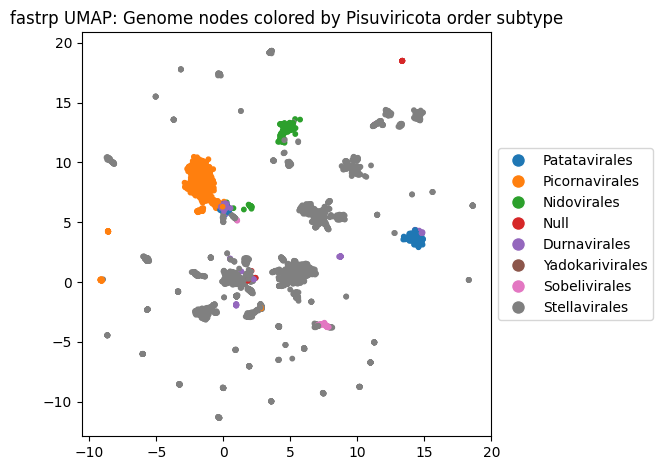

In [18]:
# Plot color pisuviricota by order subtypes

unique_pisu_order = exported_projection.loc[
    (exported_projection['nodeLabels'] == node_label) &
    (exported_projection['phylum'] == 'Pisuviricota'), 'order'].unique()

pisu_order_palette = sns.color_palette("tab10", len(unique_pisu_order))
pisu_order_palette = {order: color for order, color in zip(unique_pisu_order, pisu_order_palette)}
exported_projection['pisu_order_color'] = exported_projection['order'].map(pisu_order_palette)
exported_projection['pisu_order_color'] = exported_projection['pisu_order_color'].fillna('grey')


plt.scatter(
    umap_emb[exported_projection.nodeLabels == node_label, 0],
    umap_emb[exported_projection.nodeLabels == node_label, 1],
    c=exported_projection.loc[exported_projection.nodeLabels == node_label, 'pisu_order_color'],
    s=10
)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in pisu_order_palette.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'{target_property} UMAP: {node_label} nodes colored by Pisuviricota order subtype')
fig = plt.gcf()
plt.tight_layout()

plt.show()

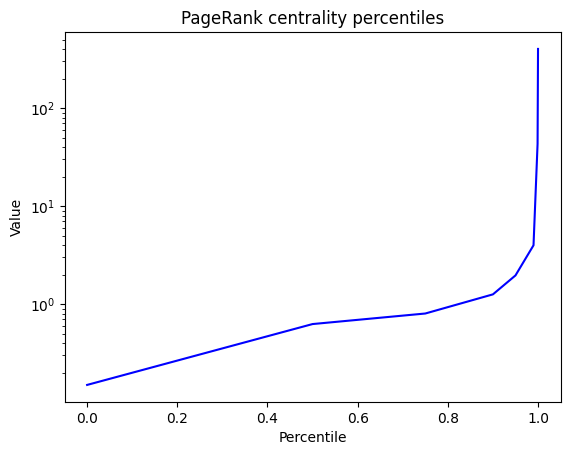

<function matplotlib.pyplot.show(close=None, block=None)>

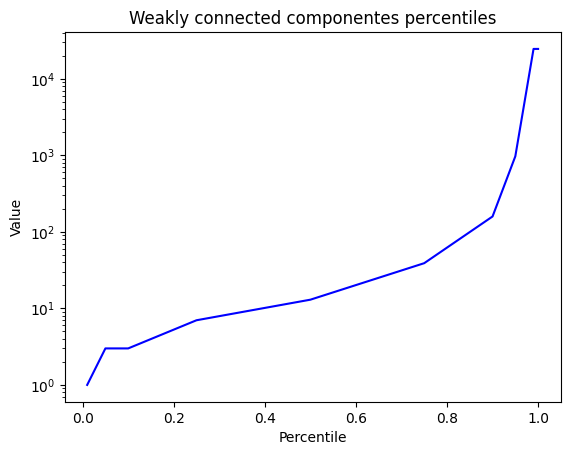

In [59]:
# Community and centrality stats percentile plots

pagerank_centrality = {'min': 0.14999961853027344,
 'max': 401.8632802963257,
 'p90': 1.259108543395996,
 'p999': 43.200682640075684,
 'p99': 3.9886465072631836,
 'p50': 0.626673698425293,
 'p75': 0.802912712097168,
 'p95': 1.9645071029663086,
 'mean': 0.9999228585250909}

#  plot pagerank percentiles 
fig, ax = plt.subplots()
xs = np.array([0.0, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1])
ys = np.array([
    pagerank_centrality['min'],
    pagerank_centrality['p50'],
    pagerank_centrality['p75'],
    pagerank_centrality['p90'],
    pagerank_centrality['p95'],
    pagerank_centrality['p99'],
    pagerank_centrality['p999'],
    pagerank_centrality['max'],
])
ax.plot(xs, ys, label='PageRank centrality', color='blue')
ax.set_xlabel('Percentile')
ax.set_ylabel('Value')
ax.set_title('PageRank centrality percentiles')
ax.set_yscale('log')
plt.show()

# undirected
weakly_connected_components = {'min': 1,
 'p5': 3,
 'max': 24614,
 'p999': 24614,
 'p99': 24614,
 'p1': 1,
 'p10': 3,
 'p90': 159,
 'p50': 13,
 'p25': 7,
 'p75': 39,
 'p95': 972,
 'mean': 428.03846153846155}

global_node_count = 33387
global_triangle_count = 245916

fig, ax = plt.subplots()
xs = np.array([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1])
ys = np.array([
    weakly_connected_components['p1'], 
    weakly_connected_components['p5'], 
    weakly_connected_components['p10'], 
    weakly_connected_components['p25'], 
    weakly_connected_components['p50'], 
    weakly_connected_components['p75'],
    weakly_connected_components['p90'],
    weakly_connected_components['p95'],
    weakly_connected_components['p99'],
    weakly_connected_components['p999'],
    weakly_connected_components['max'],
])

ax.plot(xs, ys, label='Weakly connected componentes', color='blue')
ax.set_xlabel('Percentile')
ax.set_ylabel('Value')
ax.set_title('Weakly connected componentes percentiles')
ax.set_yscale('log')
plt.show

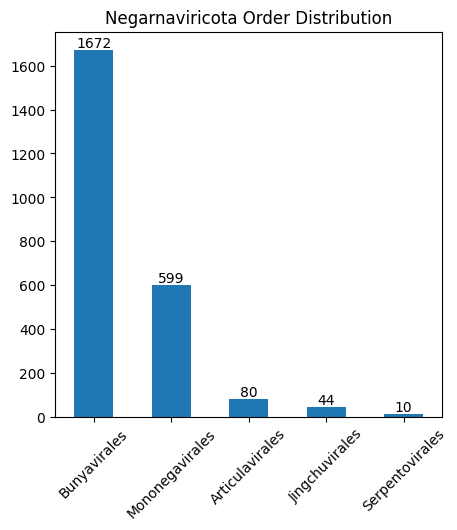

In [28]:
# Debugging plots

plt.figure(figsize=(5, 5))
exported_projection.loc[
    (exported_projection['nodeLabels'] == node_label) &
    (exported_projection[target_rank] == 'Negarnaviricota'), 'family'].value_counts().plot(kind='bar')

for i in plt.gca().patches:
    plt.gca().text(i.get_x() + i.get_width() / 2, i.get_height() + 0.1, str(int(i.get_height())), ha='center', va='bottom')

plt.title('Negarnaviricota Order Distribution')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()

In [19]:
predictions = pd.read_csv(DATASET_DIR + 'pred_genome_nodes.csv')
projection_predictions = pd.merge(
    exported_projection,
    predictions,
    left_on='nodeId',
    right_on='nodeId',
    how='left'
)

true_positives = projection_predictions.loc[
    (projection_predictions['nodeLabels'] == node_label) &
    (projection_predictions['order'] == 'Picornavirales') &
    (projection_predictions['predictedClass'] == 1)
]

true_negatives = projection_predictions.loc[
    (projection_predictions['nodeLabels'] == node_label) &
    (projection_predictions['order'] != 'Picornavirales') &
    (projection_predictions['predictedClass'] == 0)
]

false_negatives = projection_predictions.loc[
    (projection_predictions['nodeLabels'] == node_label) &
    (projection_predictions['order'] == 'Picornavirales') &
    (projection_predictions['predictedClass'] == 0)
]

false_positives = projection_predictions.loc[
    (projection_predictions['nodeLabels'] == node_label) &
    (projection_predictions['order'] != 'Picornavirales') &
    (projection_predictions['predictedClass'] == 1)
]


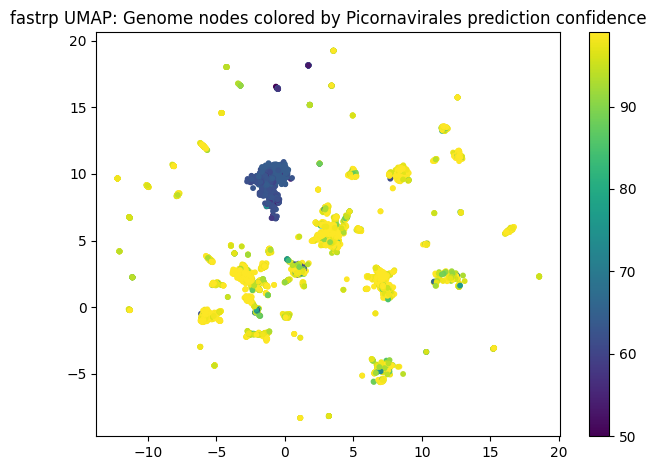

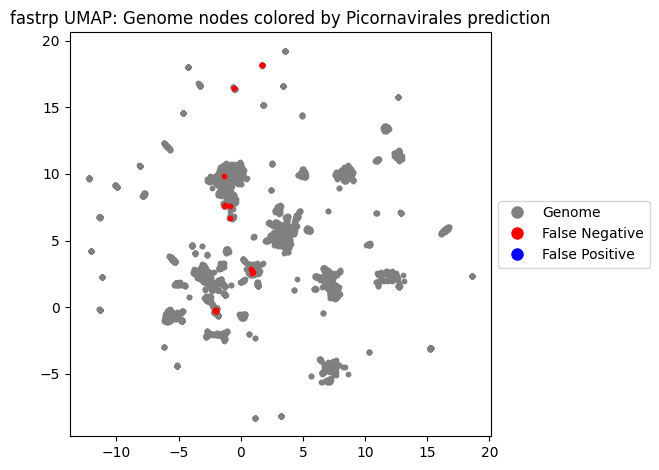

In [134]:
# Plot color of confidence of picornavirales prediction

plt.scatter(
    umap_emb[projection_predictions.nodeLabels == node_label, 0],
    umap_emb[projection_predictions.nodeLabels == node_label, 1],
    c=projection_predictions.loc[projection_predictions.nodeLabels == node_label, 'confidence'],
    s=10
)
plt.colorbar()
plt.title(f'{target_property} UMAP: {node_label} nodes colored by Picornavirales prediction confidence')
fig = plt.gcf()
plt.tight_layout()
plt.show()


plt.scatter(
    umap_emb[projection_predictions.nodeLabels == node_label, 0],
    umap_emb[projection_predictions.nodeLabels == node_label, 1],
    c='grey',
    s=10
)
plt.scatter(
    umap_emb[false_negatives.index, 0],
    umap_emb[false_negatives.index, 1],
    c='red',
    s=10
)
plt.scatter(
    umap_emb[false_positives.index, 0],
    umap_emb[false_positives.index, 1],
    c='blue',
    s=10
)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Genome',
               markerfacecolor='grey', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Negative',
               markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Positive',
                markerfacecolor='blue', markersize=10),
]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'{target_property} UMAP: {node_label} nodes colored by Picornavirales prediction')
fig = plt.gcf()
plt.tight_layout()
plt.show()

In [135]:
tp_counts = collections.Counter()
tp_seq = []
tp_fts = []
tp_degrees = []
for accession in true_positives['accession'].tolist():
    tp_counts[gb_cache[accession].annotations['molecule_type']] += 1
    tp_counts[gb_cache[accession].annotations['topology']] += 1
    tp_seq.append(len(gb_cache[accession].seq))
    tp_fts.append(len(gb_cache[accession].features))
    tp_degrees.append(projection_predictions.loc[
        exported_projection['accession'] == accession, 'degree'].values[0])

tn_counts = collections.Counter()
tn_seq = []
tn_fts = []
tn_degrees = []
for accession in true_negatives['accession'].tolist():
    tn_counts[gb_cache[accession].annotations['molecule_type']] += 1
    tn_counts[gb_cache[accession].annotations['topology']] += 1
    tn_seq.append(len(gb_cache[accession].seq))
    tn_fts.append(len(gb_cache[accession].features))
    tn_degrees.append(projection_predictions.loc[
        exported_projection['accession'] == accession, 'degree'].values[0])


fn_counts = collections.Counter()
fn_seq = []
fn_fts = []
fn_degrees = []
for accession in false_negatives['accession'].tolist():
    fn_counts[gb_cache[accession].annotations['molecule_type']] += 1
    fn_counts[gb_cache[accession].annotations['topology']] += 1
    fn_seq.append(len(gb_cache[accession].seq))
    fn_fts.append(len(gb_cache[accession].features))
    fn_degrees.append(projection_predictions.loc[
        exported_projection['accession'] == accession, 'degree'].values[0])

fp_counts = collections.Counter()
fp_seq = []
fp_fts = []
fp_degrees = []
for accession in false_positives['accession'].tolist():
    fp_counts[gb_cache[accession].annotations['molecule_type']] += 1
    fp_counts[gb_cache[accession].annotations['topology']] += 1
    fp_seq.append(len(gb_cache[accession].seq))
    fp_fts.append(len(gb_cache[accession].features))
    fp_degrees.append(projection_predictions.loc[
        exported_projection['accession'] == accession, 'degree'].values[0])

print(
    fn_counts, fp_counts
)

print(
    tn_counts, tp_counts
)

print(
    np.mean(fn_seq),
    np.mean(fp_seq)
)

print(
    np.mean(tn_seq),
    np.mean(tp_seq),
)

print(
    np.mean(fn_fts),
    np.mean(fp_fts)
)

print(
    np.mean(tn_fts),
    np.mean(tp_fts),
)


print(
    np.mean(fn_degrees),
    np.mean(fp_degrees)
)

print(
    np.mean(tn_degrees),
    np.mean(tp_degrees),
)


Counter({'linear': 17, 'RNA': 16, 'ss-RNA': 1}) Counter()
Counter({'linear': 5538, 'RNA': 3574, 'cRNA': 1500, 'ss-RNA': 213, 'DNA': 130, 'mRNA': 90, 'ds-RNA': 62, 'circular': 31}) Counter({'linear': 867, 'RNA': 716, 'ss-RNA': 131, 'mRNA': 18, 'cRNA': 1, 'ds-RNA': 1})
4597.0 nan
6263.885078110971 6981.680507497116
4.647058823529412 nan
6.089244029448734 7.342560553633218
1.9411764705882353 nan
3.7721314419105765 6.083044982698962


/home/ec2-user/miniconda3/envs/rnalab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec2-user/miniconda3/envs/rnalab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/ec2-user/miniconda3/envs/rnalab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec2-user/miniconda3/envs/rnalab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


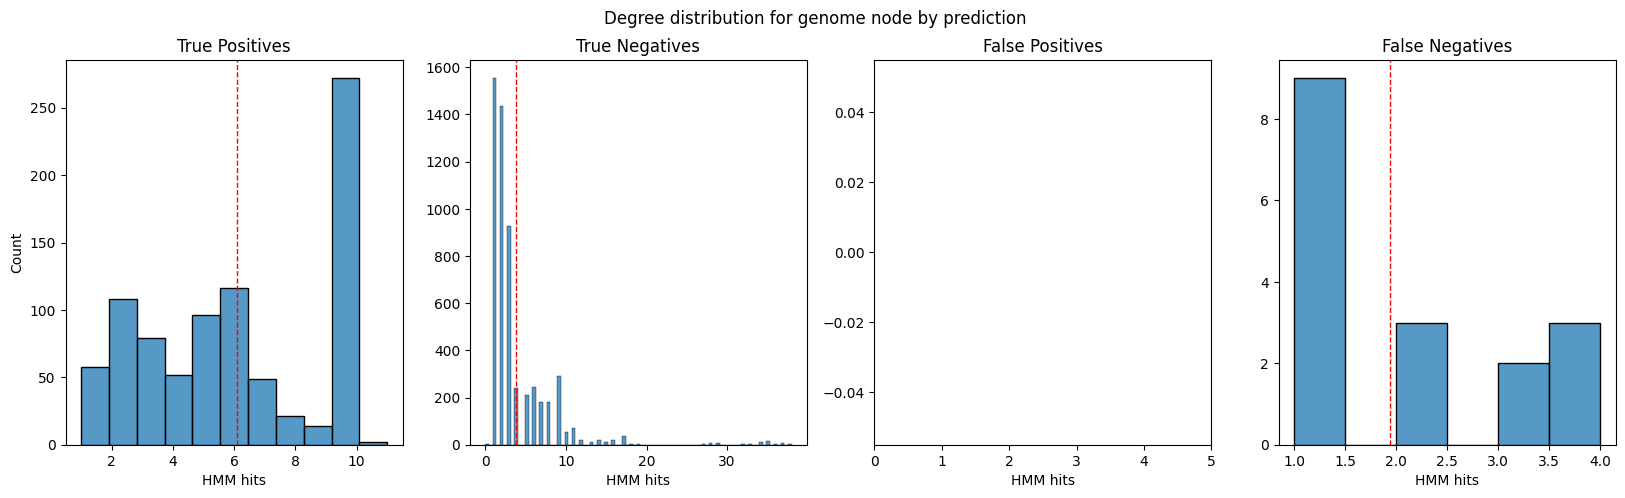

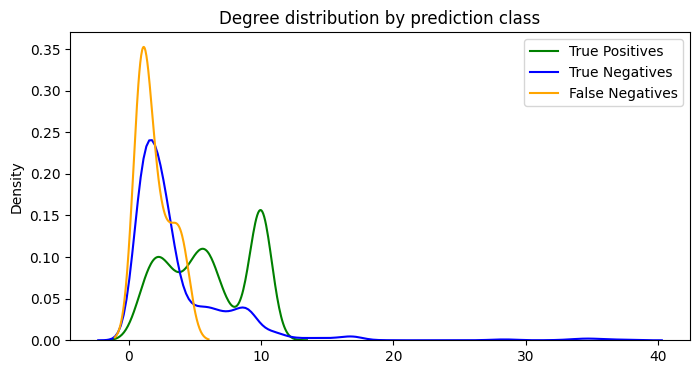

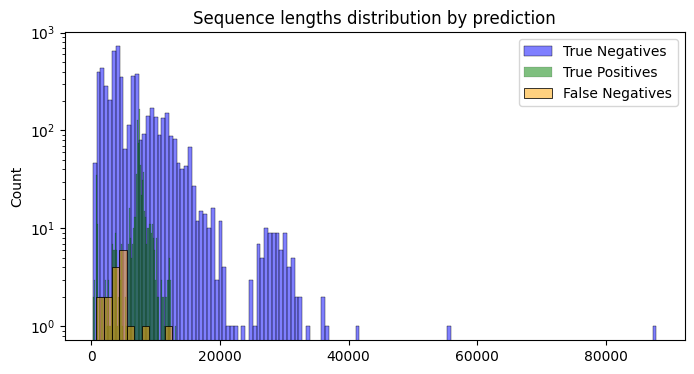

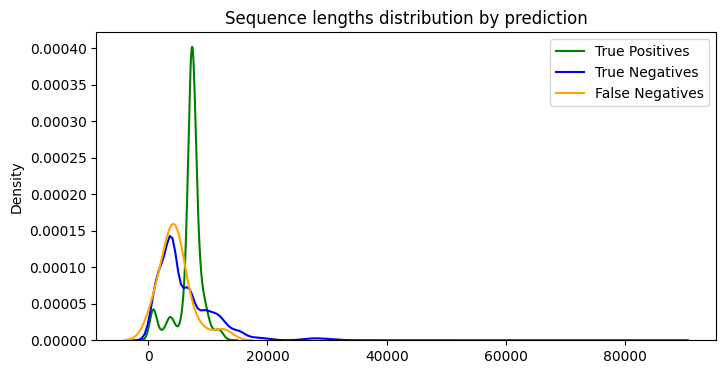

In [136]:
# plot the degree distrubutions and color by true positive, false positive, true negative, false negative

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(tp_degrees, ax=ax[0])
ax[0].set_title('True Positives')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('HMM hits')
ax[0].axvline(np.mean(tp_degrees), color='red', linestyle='dashed', linewidth=1)


sns.histplot(tn_degrees, ax=ax[1])
ax[1].set_title('True Negatives')
ax[1].set_ylabel('')
ax[1].set_xlabel('HMM hits')
ax[1].axvline(np.mean(tn_degrees), color='red', linestyle='dashed', linewidth=1)


sns.histplot(fp_degrees, ax=ax[2])
ax[2].set_title('False Positives')
ax[2].set_ylabel('')
ax[2].set_xlabel('HMM hits')
ax[2].set_xlim(left=0, right=5)

ax[2].axvline(np.mean(fp_degrees), color='red', linestyle='dashed', linewidth=1)



sns.histplot(fn_degrees, ax=ax[3])
ax[3].set_title('False Negatives')
ax[3].set_ylabel('')
ax[3].set_xlabel('HMM hits')
ax[3].axvline(np.mean(fn_degrees), color='red', linestyle='dashed', linewidth=1)
plt.suptitle('Degree distribution for genome node by prediction')
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.kdeplot(tp_degrees, ax=ax, color='green', label='True Positives')
sns.kdeplot(tn_degrees, ax=ax, color='blue', label='True Negatives')
sns.kdeplot(fp_degrees, ax=ax, color='red', label='False Positives')
sns.kdeplot(fn_degrees, ax=ax, color='orange', label='False Negatives')
ax.set_title('Degree distribution by prediction class')
plt.legend()
plt.show()

# plot the sequence length distributions and color by true positive, false positive, true negative, false negative


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(tn_seq, ax=ax, color='blue', label='True Negatives', alpha=0.5)
sns.histplot(tp_seq, ax=ax, color='green', label='True Positives', alpha=0.5)
sns.histplot(fp_seq, ax=ax, color='red', label='False Positives', alpha=0.5)
sns.histplot(fn_seq, ax=ax, color='orange', label='False Negatives', alpha=0.5)
ax.set_yscale('log')
ax.set_title('Sequence lengths distribution by prediction')
plt.legend()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.kdeplot(tp_seq, ax=ax, color='green', label='True Positives')
sns.kdeplot(tn_seq, ax=ax, color='blue', label='True Negatives')
sns.kdeplot(fp_seq, ax=ax, color='red', label='False Positives')
sns.kdeplot(fn_seq, ax=ax, color='orange', label='False Negatives')
ax.set_title('Sequence lengths distribution by prediction')
plt.legend()
plt.show()


In [20]:
def get_knn(source_node_ids, k = 5):
    return gds.knn.filtered.stream(
        G=gds.graph.get(projection_name),
        relationshipTypes=["*"],
        # randomSeed=RANDOM_SEED,
        topK=k,
        sourceNodeFilter=source_node_ids,
        targetNodeFilter="Genome",
        nodeProperties=[target_property],
        # similarityCutoff=0.5,
    )

false_positives_node_ids = false_positives['nodeId'].tolist()
false_negatives_node_ids = false_negatives['nodeId'].tolist()

false_positives_knn = get_knn(false_positives_node_ids)
false_negatives_knn = get_knn(false_negatives_node_ids)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

Knn: 100%|██████████| 100.0/100 [01:14<00:00,  1.34%/s]
Knn: 100%|██████████| 100.0/100 [00:55<00:00,  1.81%/s]


### Diversity UMAP plots

In [36]:
# plot the diversity of FuncDomains

pfam_diversity = pd.read_csv(DATASET_DIR + 'pfam_diversity.csv')
pfam_diversity_merged = pd.merge(
    exported_projection,
    pfam_diversity,
    left_on='accession',
    right_on='pfam_acc',
    how='left'
)

gb_diversity = pd.read_csv(DATASET_DIR + 'genome_diversity.csv')
gb_diversity_merged = pd.merge(
    exported_projection,
    gb_diversity,
    left_on='accession',
    right_on='gb_acc',
    how='left'
)

Text(0.5, 1.0, 'UMAP of FuncDomainSet nodes colored by max taxon distance')

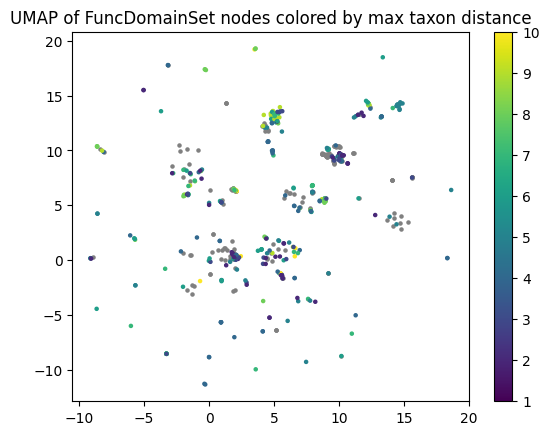

In [20]:
diversity_key = 'max_taxon_distance'

pfam_diversity_merged[diversity_key] = pfam_diversity_merged[diversity_key].fillna(0)

skip_condition = (pfam_diversity_merged.nodeLabels == 'FuncDomainSet') & (pfam_diversity_merged[diversity_key] == 0)
plt.scatter(
    umap_emb[skip_condition, 0],
    umap_emb[skip_condition, 1],
    c='grey',
    s=5
)

plot_condition = (pfam_diversity_merged.nodeLabels == 'FuncDomainSet') & (pfam_diversity_merged[diversity_key] > 0) & (pfam_diversity_merged[diversity_key] <= 10)

plt.scatter(
    umap_emb[plot_condition, 0],
    umap_emb[plot_condition, 1],
    c=pfam_diversity_merged.loc[plot_condition, diversity_key],
    s=5
)
plt.colorbar()
plt.title('UMAP of FuncDomainSet nodes colored by max taxon distance')

Text(0.5, 1.0, 'UMAP of FuncDomainSet nodes colored by max taxon distance')

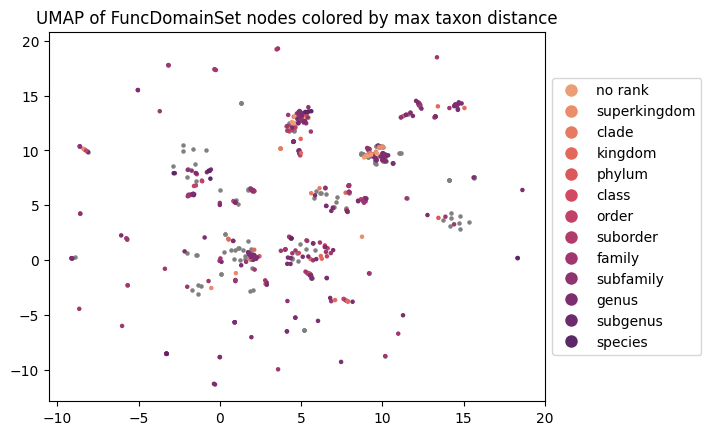

In [49]:
diversity_key = 'lcaRank'

pfam_diversity_merged[diversity_key] = pfam_diversity_merged[diversity_key].fillna(0)

# create color pallete for FuncDomainSet based on lcaRank values
# unique_rank = pfam_diversity_merged.loc[
#     pfam_diversity_merged['nodeLabels'] == 'FuncDomainSet', diversity_key].unique()
# unique_rank = unique_rank[unique_rank != None]
# unique_rank = unique_rank[~pd.isnull(unique_rank)]
# rank_palette = sns.color_palette("tab10", len(unique_rank))
# rank_palette = {rank: color for rank, color in zip(unique_rank, rank_palette)}
# pfam_diversity_merged['rank_color'] = pfam_diversity_merged[diversity_key].map(rank_palette)

rank_ordering =[
    'no rank',
    'superkingdom',
    'clade',
    'kingdom',
    'phylum',
    'class',
    'order',
    'suborder',
    'family',
    'subfamily',
    'genus',
    'subgenus',
    'species',
]
rank_palette = sns.color_palette("flare", len(rank_ordering))
rank_palette = {rank: color for rank, color in zip(rank_ordering, rank_palette)}
pfam_diversity_merged['rank_color'] = pfam_diversity_merged[diversity_key].map(rank_palette)


skip_condition = (pfam_diversity_merged.nodeLabels == 'FuncDomainSet') & (pfam_diversity_merged[diversity_key] == 0)
plt.scatter(
    umap_emb[skip_condition, 0],
    umap_emb[skip_condition, 1],
    c='grey',
    s=5
)
plot_condition = (pfam_diversity_merged.nodeLabels == 'FuncDomainSet') & (pfam_diversity_merged[diversity_key] != 0)
plt.scatter(
    umap_emb[plot_condition, 0],
    umap_emb[plot_condition, 1],
    c=pfam_diversity_merged.loc[plot_condition, 'rank_color'],
    s=5
)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in rank_palette.items()]
legend_elements = [elem for elem in legend_elements if elem.get_label() != "0"]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('UMAP of FuncDomainSet nodes colored by max taxon distance')

Text(0.5, 1.0, 'UMAP of Genome nodes colored by mean_diversity')

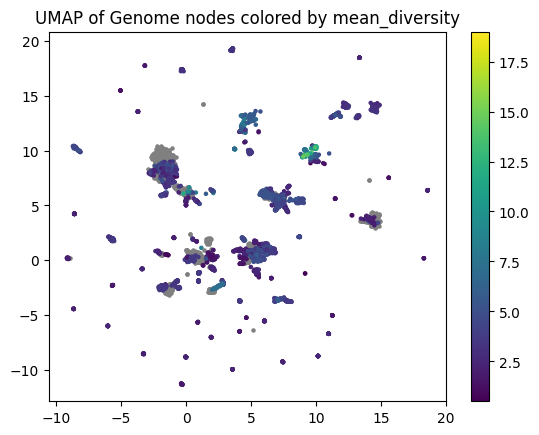

In [50]:
diversity_key = 'mean_diversity' # 'max_diversity', 'sum_distance, 'mean_distance', 'mean_diversity'

gb_diversity_merged[diversity_key] = gb_diversity_merged[diversity_key].fillna(0)

skip_condition = (gb_diversity_merged.nodeLabels == 'Genome') & (gb_diversity_merged[diversity_key] == 0)
plt.scatter(
    umap_emb[skip_condition, 0],
    umap_emb[skip_condition, 1],
    c='grey',
    s=5
)

plot_condition = (gb_diversity_merged.nodeLabels == 'Genome') & (gb_diversity_merged[diversity_key] > 0) #& (gb_diversity_merged[diversity_key] <= 10)

plt.scatter(
    umap_emb[plot_condition, 0],
    umap_emb[plot_condition, 1],
    c=gb_diversity_merged.loc[plot_condition, diversity_key],
    s=5
)
plt.colorbar()
plt.title(f'UMAP of Genome nodes colored by {diversity_key}')


## Export Datasets

In [118]:
# Export dataset nodes

def set_app_id(df):
    # nodeId is not stable,  include a reference to a stable node attribute
    config = {
        'Genome': 'accession',
        'FuncDomain': 'name',
        'FuncDomainSet': 'accession',
        'FuncDomainClan': 'accession',
    
    }
    df['appId'] = None
    for node_label, id_column in config.items():
        df.loc[df['nodeLabels'] == node_label, 'appId'] = df.loc[
            df['nodeLabels'] == node_label, id_column]


def add_top_k_class_label_col(df, k=10, rank_col='topPhylum', target_rank='phylum'):
    # only modify node_label
    df[rank_col] = None
    top_k = df.loc[df['nodeLabels'] == 'Genome', target_rank].value_counts().index[:k]
    label_map = {label: i for i, label in enumerate(top_k)}

    df.loc[df['nodeLabels'] == 'Genome', rank_col] = df.loc[
        df['nodeLabels'] == 'Genome', target_rank].map(label_map)
    df.loc[
        (df['nodeLabels'] == 'Genome') &
        (~df[target_rank].isin(top_k)), rank_col] = -1
    df[rank_col] = df[rank_col].fillna(-1).astype(int)

    return df
    

exported_projection = add_top_k_rank_col(exported_projection)
print(exported_projection[rank_col].value_counts())


def set_class_labels(df):
    # Binary class, rank: phylum, 1547 examples
    df['isPisuviricota'] = 0
    df.loc[df['phylum'] == 'Pisuviricota', 'isPisuviricota'] = 1

    # Binary class, rank: order, 878 examples
    df['isPicornavirales'] = 0
    df.loc[df['order'] == 'Picornavirales', 'isPicornavirales'] = 1
    
    # Binary class, rank:  order, 1672 examples
    df['isEllioviricetes'] = 0
    df.loc[df['order'] == 'Ellioviricetes', 'isEllioviricetes'] = 1
    
    # Binary class, rank: family, 615 examples
    df['isPicornaviridae'] = 0
    df.loc[df['family'] == 'Picornaviridae', 'isPicornaviridae'] = 1

    # Binary class, rank:  genus, 77 examples
    df['isOrthoflavivirus'] = 0
    df.loc[df['genus'] == 'Orthoflavivirus', 'isOrthoflavivirus'] = 1

    # Multi-class, top k most common classes as ints
    add_top_k_class_label_col(df, 10)

set_app_id(exported_projection)
set_class_labels(exported_projection)

nodes = exported_projection[[
    'nodeId',
    'appId',
    'nodeLabels',
    'degree',
    'accession',
    'name',
    'annotation',
    'species',
    'genus',
    'family',
    'order',
    'phylum',
    'class',
    'isPisuviricota',
    'isPicornavirales',
    'isEllioviricetes',
    'isPicornaviridae',
    'isOrthoflavivirus',
    'topPhylum',
]]

nodes.to_csv(DATASET_DIR + 'nodes.csv', index=False)

topPhylum
Negarnaviricota     2434
Pisuviricota        1556
Lenarviricota       1036
Kitrinoviricota      977
Duplornaviricota     291
Artverviricota       138
Null                  21
Name: count, dtype: int64


/tmp/ipykernel_3795/3732652514.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rank_col] = df[rank_col].fillna(-1).astype(int)


In [119]:
# Export dataset edges

edges = gds.graph.relationshipProperties.stream(
    get_projection(gds, get_projection_name()),
    relationship_properties=['identity', 'linkscore'],
)

def set_edge_weights(df):
    config = {
        'HasReg': 'identity',
        'HasMember': 'identity',
        'hasNextDomainSet': 'identity',
        'hasClanEntry': 'identity',
        'homologousTo': 'identity',
        'hasClanHomology': 'linkscore',
    }
    df['weight'] = None
    edges.drop(
        edges.loc[
            (edges['relationshipType'] == 'hasClanHomology') & (edges['relationshipProperty'] == 'identity')
        ].index, inplace=True
    )
    for relationship_type, weight_column in config.items():
        condition = (df['relationshipType'] == relationship_type) & (df['relationshipProperty'] == weight_column)
        if relationship_type == 'hasClanHomology':
            df.loc[
                condition, 'weight'] = 1 - df.loc[
                condition, 'propertyValue']
        else :
            df.loc[
                condition, 'weight'] = df.loc[
                condition, 'propertyValue']
    edges.dropna(subset=['weight'], inplace=True)

set_edge_weights(edges)

edges.to_csv(DATASET_DIR + 'edges.csv', index=False)

In [51]:
# drop projection
gds.graph.drop(get_projection_name())

graphName                                         exploration_projection_1
database                                                             neo4j
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            33453
relationshipCount                                                  1345820
configuration            {'relationshipProjection': {'HasReg': {'aggreg...
density                                                           0.001203
creationTime                           2024-04-22T15:16:18.864758401+00:00
modificationTime                       2024-04-22T15:19:25.329273718+00:00
schema                   {'graphProperties': {}, 'nodes': {'FuncDomainS...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'FuncDomainS...
Name: 0, dtype: object

## Graphistry

In [186]:
import graphistry
graphistry.register(
    api=3,
    username=os.getenv('GRAPHISTRY_USERNAME'),
    password=os.getenv('GRAPHISTRY_PASSWORD'),
)

In [190]:
g = graphistry.bind()

nodes['type'] = nodes['nodeLabels']

g = g.bind(
    source='sourceNodeId',
    destination='targetNodeId',
    edge_weight='weight',
).edges(edges)

g = g.bind(
    node='nodeId',
    point_label='appId',
    point_size=None,
).nodes(nodes)



params = {
        'play': 2000,
        'menu': True, 
        'info': True,
        'showArrows': True,
        'pointSize': 2.0, 
        'edgeOpacity': 0.25, 
        'pointOpacity': 1.0,
        'linLog': True, 
        'compactLayout': True,
        'strongGravity': True,
        'dissuadeHubs': False,
        'edgeInfluence': 5,
        'showLabelPropertiesOnHover': True,
        'pointsOfInterestMax': 10,
      }


g = g.addStyle(
    bg={
        'color': 'black',
})

g.plot()